In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

sys.path.append("..")
from swarmalatorlib.template import Swarmalators2D

In [2]:
from main import Strogatz2017, Strogatz2017Fix
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
Jrange = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 3, 0.1),
])
agentsNumRange = [1000, 2000]  # np.arange(1000, 5001, 1000)


# models = [
#     Strogatz2017(agentsNum=agentsNum, dt=0.1, K=1, J=J, 
#                  randomSeed=randomSeed, tqdm=False, savePath="data", shotsnaps=1)
#     for J, agentsNum in tqdm(product(Jrange, agentsNumRange), total=len(Jrange) * len(agentsNumRange))
# ]

In [ ]:
def get_last_state(model, index=-1):
    targetPath = f"./data/{model}.h5"

    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")

    TNum = totalPositionX.shape[0] // model.agentsNum

    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)

    positionLim = np.max(np.abs(totalPositionX)) * 1.1

    positionX = totalPositionX[index]
    phaseTheta = totalPhaseTheta[index]

    return positionX, phaseTheta, positionLim


# for model in models:

#     positionX, phaseTheta, positionLim = get_last_state(model)

#     plt.subplots(figsize=(5, 5))
#     plt.scatter(positionX[:, 0], positionX[:, 1], s=5, cmap=new_cmap, vmin=0, vmax=2 * np.pi, alpha=0.8)
#     plt.title(f"{model}")
#     plt.show()

In [9]:
p = 1

In [ ]:
Rs = pd.DataFrame(index=Jrange, columns=agentsNumRange)
Rs.index.name = "J"
Rs.columns.name = "agentsNum"

for J, agentsNum in tqdm(product(Jrange, agentsNumRange), total=len(Jrange) * len(agentsNumRange)):
    model = Strogatz2017Fix(agentsNum=agentsNum, dt=0.1, K=1, J=J, p=p,
                 randomSeed=randomSeed, tqdm=False, savePath="data", shotsnaps=1)
    positionX, phaseTheta, positionLim = get_last_state(model)
    centor = positionX.mean(axis=0)
    distance = np.linalg.norm(positionX - centor, axis=1)
    radius = np.mean(np.sort(distance)[-int(agentsNum * 0.05):])
    Rs.loc[J, agentsNum] = radius

In [ ]:
Rs.to_csv(f"不含相位半径{p:.1f}.csv")

In [22]:
Rs = pd.read_csv("不含相位半径.csv", index_col=0)
Rs = Rs[Rs.index <= 1]
Jrange = Rs.index.values

[1.12272202 1.00087827]


Text(0.5, 1.0, 'p=1.0, R=(1.123 / (1 + x)) ^ 1.001')

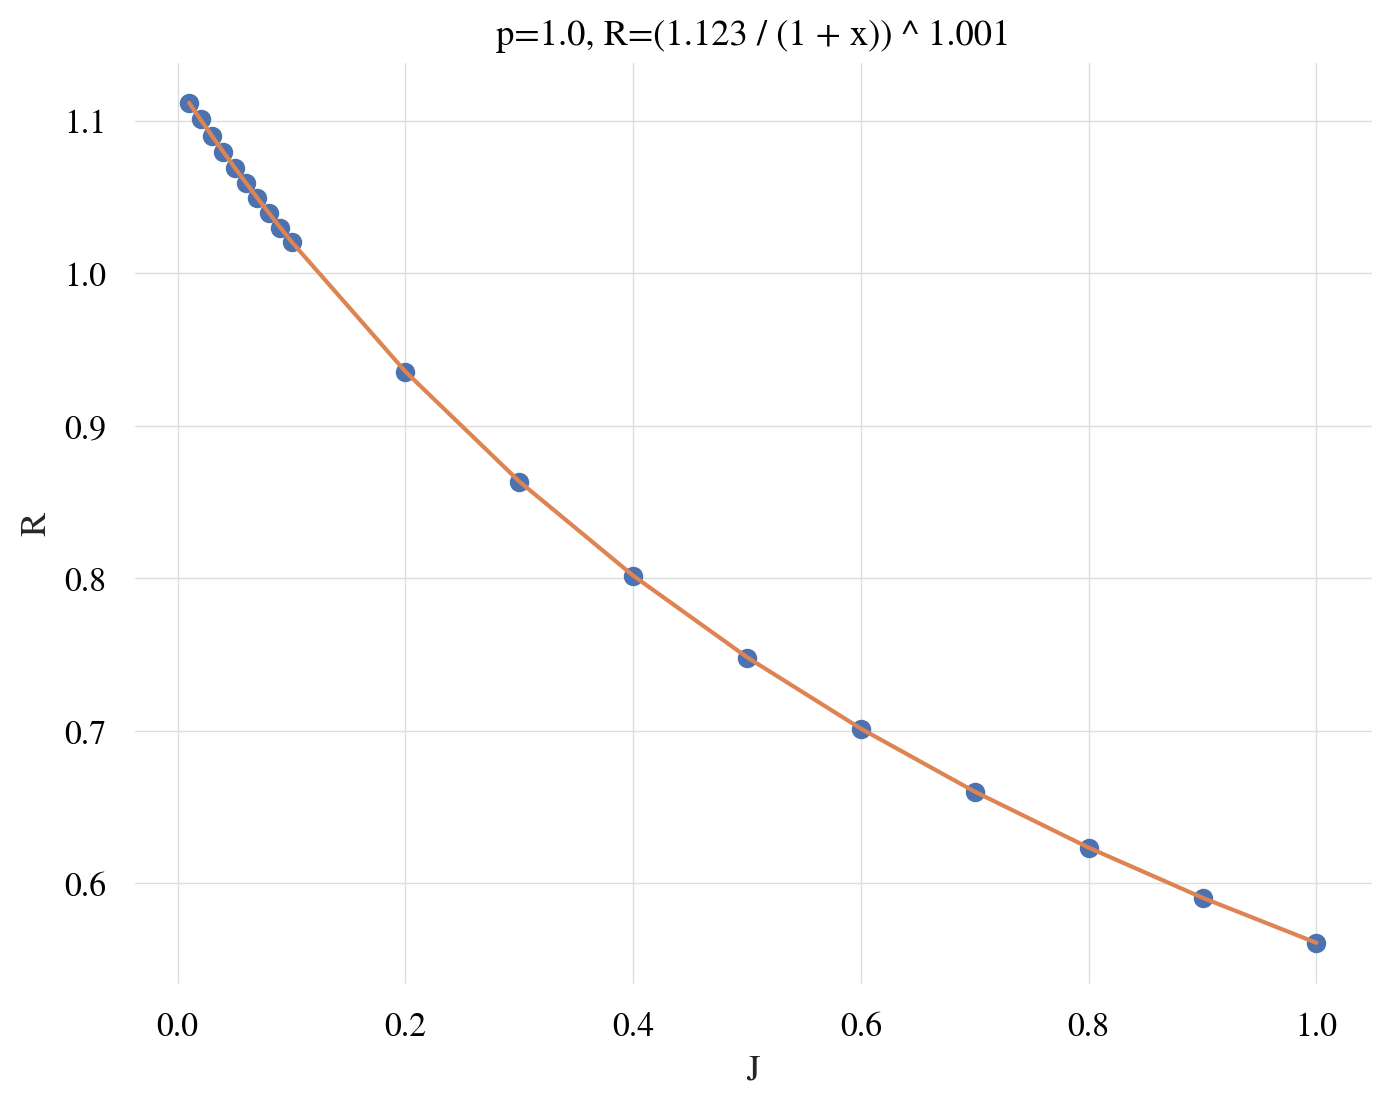

In [25]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, b, c):
    return (b / (1 + x)) ** c

R = Rs["1000"].values

popt, pcov = curve_fit(func, Jrange, R, maxfev=50000)
print(popt) 

plt.figure(figsize=(8, 6))
plt.plot(Jrange, R, "o", label="data")
plt.plot(Jrange, func(Jrange, *popt), label="fit")
plt.xlabel("J")
plt.ylabel("R")
plt.title(f"p={p:.1f}, R=({popt[0]:.3f} / (1 + x)) ^ {popt[1]:.3f}")
# plt.savefig(f"radiusFit{p:.1f}.png", dpi=200, bbox_inches="tight")

In [24]:
np.pi * 3 / 8

1.1780972450961724

[1.12268241]


Text(0.5, 1.0, 'p=1.0, R=1.123 / (1 + x)')

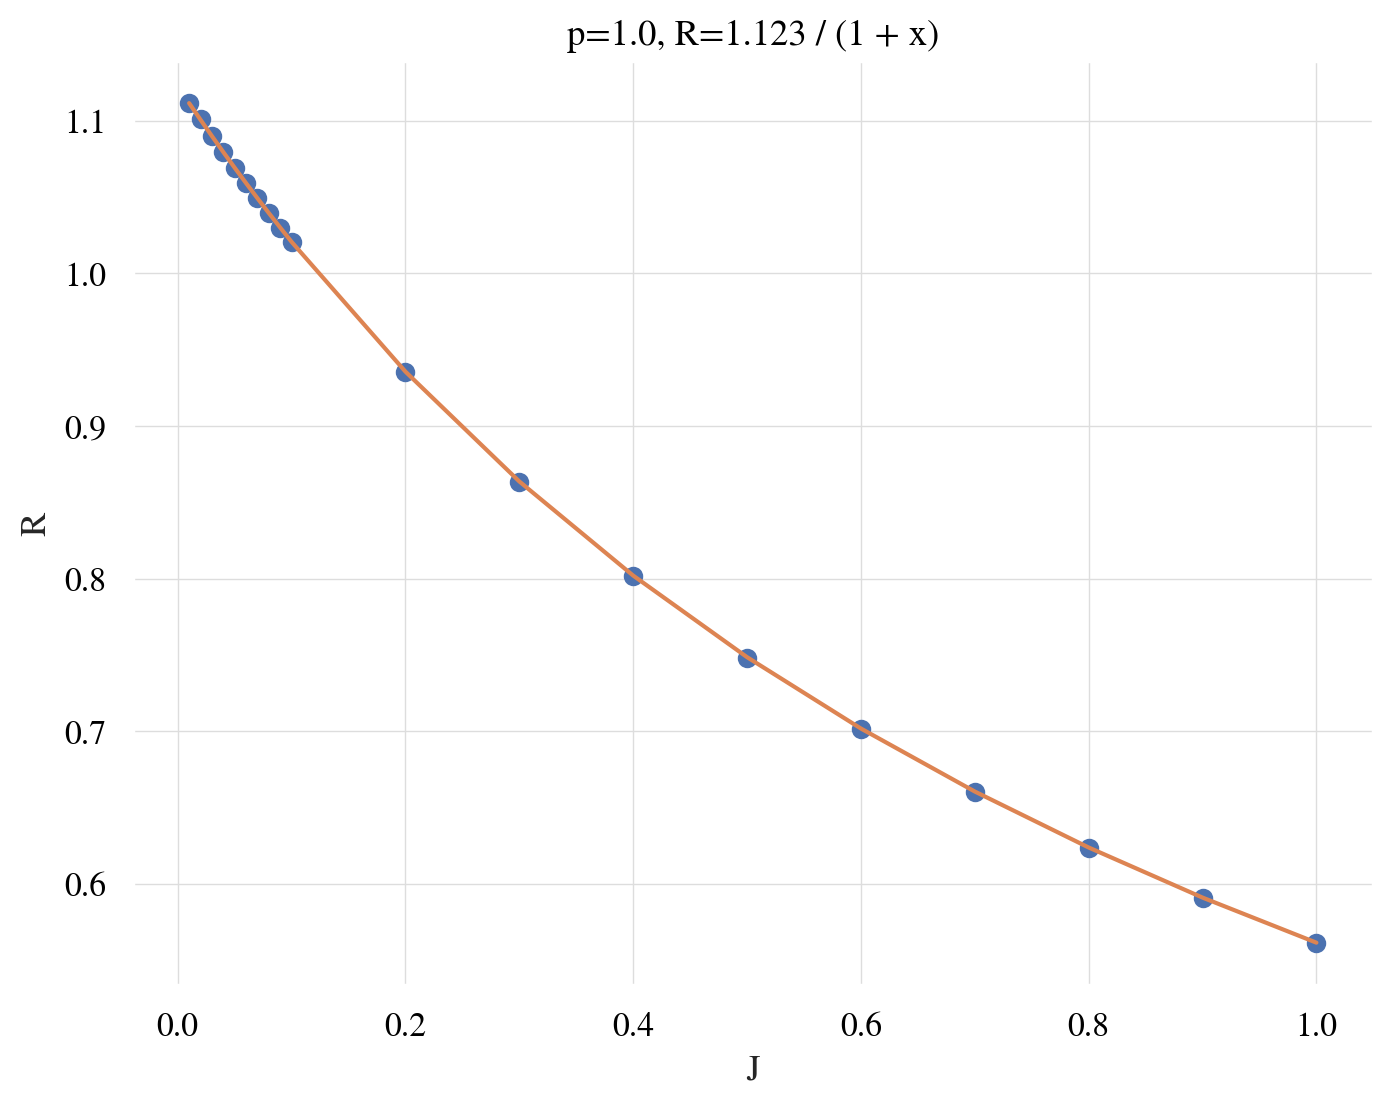

In [23]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a):
    return a / (1 + x)

R = Rs["1000"].values

popt, pcov = curve_fit(func, Jrange, R, maxfev=50000)
print(popt) 

plt.figure(figsize=(8, 6))
plt.plot(Jrange, R, "o", label="data")
plt.plot(Jrange, func(Jrange, *popt), label="fit")
plt.xlabel("J")
plt.ylabel("R")
plt.title(f"p={p:.1f}, R={popt[0]:.3f} / (1 + x)")
# plt.savefig(f"radiusFit{p:.1f}.png", dpi=200, bbox_inches="tight")

In [ ]:
idx = 1

fig = plt.figure(figsize=(len(agentsNumRange) * 5, len(Jrange) * 5))

for J, agentsNum in tqdm(product(Jrange, agentsNumRange), total=len(Jrange) * len(agentsNumRange)):

    model = Strogatz2017Fix(agentsNum=agentsNum, dt=0.1, K=1, J=J, p=p, 
                            randomSeed=randomSeed, tqdm=False, savePath="data", shotsnaps=1)
    ax = plt.subplot(len(Jrange), len(agentsNumRange), idx)
    
    try:
        positionX, phaseTheta, positionLim = get_last_state(model, index=-1)
    except:
        ax.set_title(f"{model}")
        idx += 1
        continue
    centor = positionX.mean(axis=0)
    distance = np.linalg.norm(positionX - centor, axis=1)
    radius = np.mean(np.sort(distance)[-int(agentsNum * 0.05):])
    rEnd = centor.copy()
    rEnd[0] += radius
    
    ax.scatter(positionX[:, 0], positionX[:, 1], s=5, cmap=new_cmap, vmin=0, vmax=2 * np.pi, alpha=0.8)
    ax.plot([centor[0], rEnd[0]], [centor[1], rEnd[1]], color="black", linewidth=2)
    ax.set_title(f"{model}, r={radius:.2f}")
    idx += 1
    # ax.set_xlim(-0.25, 0.25)
    # ax.set_ylim(-0.25, 0.25)
    # if idx > 10:
    #     break

plt.savefig(f"bigGraph{p:.1f}.png", dpi=100, bbox_inches="tight")
plt.close()

In [ ]:
positionX, phaseTheta, positionLim = get_last_state(model, index=-1)

In [ ]:
for agentsNum in tqdm(agentsNumRange):
    
    radiusList = []
    JtoPlot = []
    for J in Jrange:

        model = Strogatz2017Fix(agentsNum=agentsNum, dt=0.1, K=1, J=J, randomSeed=randomSeed, tqdm=False, savePath="data", shotsnaps=1)
        try:
            positionX, phaseTheta, positionLim = get_last_state(model, index=-1)
        except:
            continue
        centor = positionX.mean(axis=0)
        distance = np.linalg.norm(positionX - centor, axis=1)
        radius = np.mean(np.sort(distance)[-int(agentsNum * 0.05):])

        radiusList.append(radius)
        JtoPlot.append(J)

    plt.scatter(JtoPlot, radiusList, label=f"N={agentsNum}")
# plt.plot(Jrange, (1 + Jrange) ** (-1 / 2), alpha=0.5, label=r"$(1 + J)^{-1 / 2}$")
plt.legend()

In [ ]:
for agentsNum in tqdm(agentsNumRange):
    
    radiusList = []
    JtoPlot = []
    for J in Jrange[Jrange < 1.5]:

        model = Strogatz2017(agentsNum=agentsNum, dt=0.1, K=1, J=J, randomSeed=randomSeed, tqdm=False, savePath="data", shotsnaps=1)
        try:
            positionX, phaseTheta, positionLim = get_last_state(model, index=-1)
        except:
            continue
        centor = positionX.mean(axis=0)
        distance = np.linalg.norm(positionX - centor, axis=1)
        radius = np.mean(np.sort(distance)[-int(agentsNum * 0.01):])

        radiusList.append(radius)
        JtoPlot.append(J)

    plt.scatter(JtoPlot, radiusList, label=f"N={agentsNum}")
# plt.plot(Jrange, (1 + Jrange) ** (-1 / 2), alpha=0.5)
plt.legend()

In [2]:
import numpy as np
x1 = x2 = x3 = x4 = x5 = np.linspace(0, 1.5, 100)
y1 = y2 = y3 = y4 = y5 = (1 + x1) ** (-1 / 2)

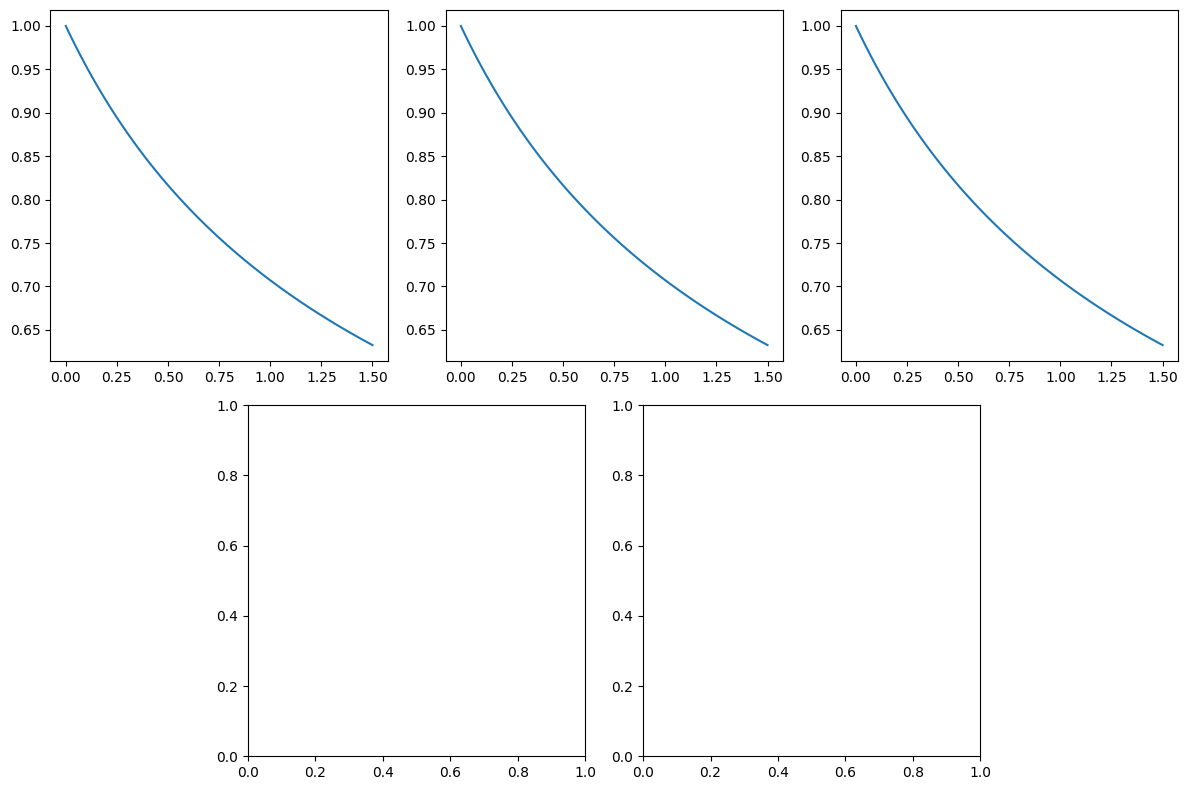

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
ax1.plot(x1, y1)
ax2.plot(x2, y2)
ax3.plot(x3, y3)

plt.tight_layout()
plt.show()